# 배울 내용
## CAM: Class Activation Map

* "모델이 어떤 곳을 보고 어떤 클래스임을 짐작하고 있는지" 확인할 수 있는 지도 
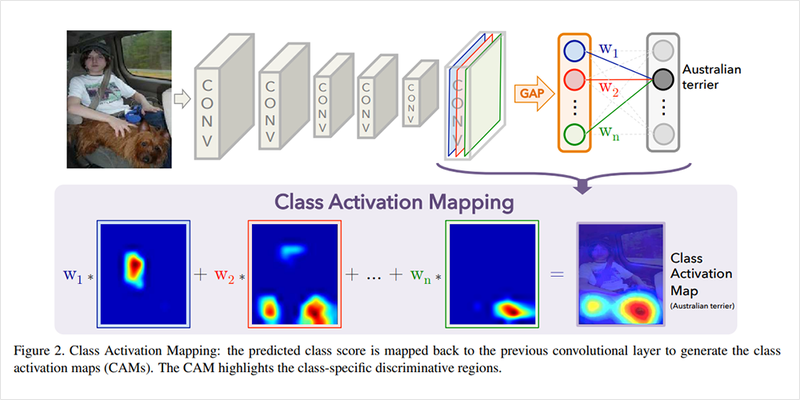

1. CAM을 얻을 수 있는 네트워크는 위 그림에서 볼 수 있습니다. 먼저 CNN 레이어를 거쳐 뽑아낸 특성 맵에 대해서 GAP을 적용합니다 (GAP을 통해 각 채널별 정보를 요약)
2. 이에 대해서 소프트맥스 레이어(소프트맥스 활성화 함수를 가지고 bias가 없는 fully connected layer)를 적용합니다. (소프트맥스 레이어는 이 정보를 보고 각 클래스에 대한 개별 채널의 중요도를 결정)
3. 이를 보간(interpolation)을 통해 적절히 원본 이미지 크기로 확대
4. 각 클래스가 활성화 맵의 어떤 부분을 주로 활성화시키는지 확인

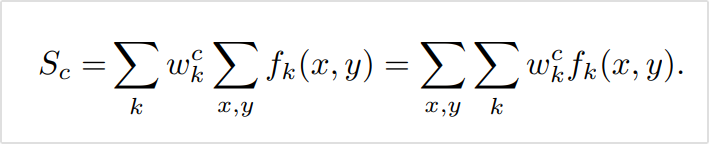
* $w_k^c$ 는 가중치값, $f_k(x,y)$는 활성화 값입니다.
* 위 식을 통해 클래스 별 점수 $S_c$를 얻을 수 있습니다.

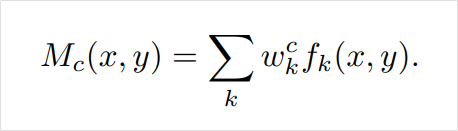
* CAM을 얻기 위해서는 클래스별 점수를 얻을때 모든 위치가 아니라 k개의 채널만을 더해 위치정보를 얻습니다.
* 즉 $M_c(x,y)$는 모델이 클래스c에 대해 각 위치를 얼마나 보고있는지 나타내게 됩니다. 

## GRAD-CAM

* CAM 에서는 GAP, CNN의 마지막 레이어를 통해 결과물을 시각화 했습니다.
* Grad-CAM을 사용하면 CNN 기반의 네트워크는 굳이 모델 구조를 변경할 필요가 없으며, 분류 문제 외의 다른 태스크들에 유연하게 대처 할 수 있습니다.
* Grad-CAM에서는 높은 분별력과 큰 dimension을 갖는 CAM을 만드는 것을 중요하게 보았습니다.

---
<center><span style="color: red"><b>GRAD-CAM의 전체구조</b></span></center>

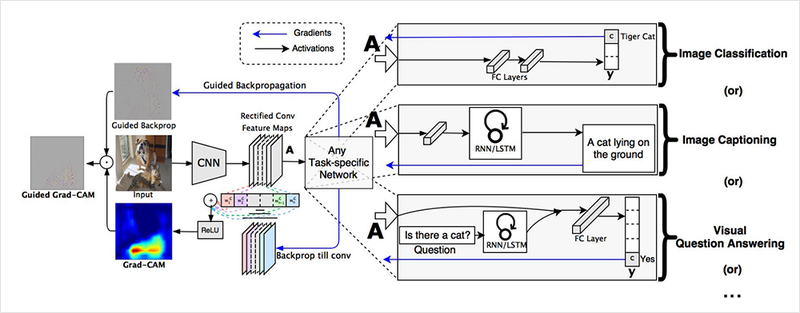

* 원하는 클래스에 대해 관찰하려는 레이어로 들어오는 Gradient를 구하여, 해당 클래스를 활성화할 때, 레이어에 어떤 부분이 중요하게 작용하는지 알 수 있습니다.

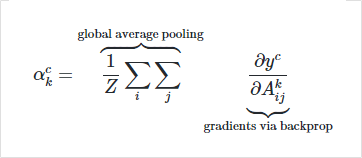

* 이렇게 찾은 Gradient에 ReLU 활성화를 시켜 불필요한 음의 값을 제거하고, 양의값의 세기를 관측합니다.

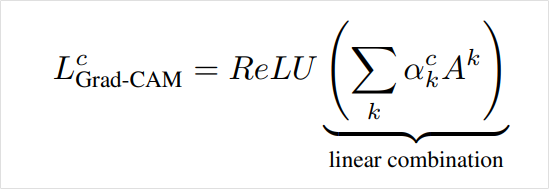

## ACoL: Adversarial Complementary Learning

* 레이어에서 활성화 된 위치정보를 통해 Object detecting 을 하는 비지도학습(Weakly-supervised Learning)
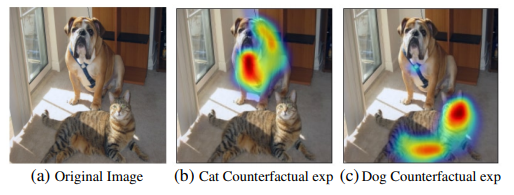
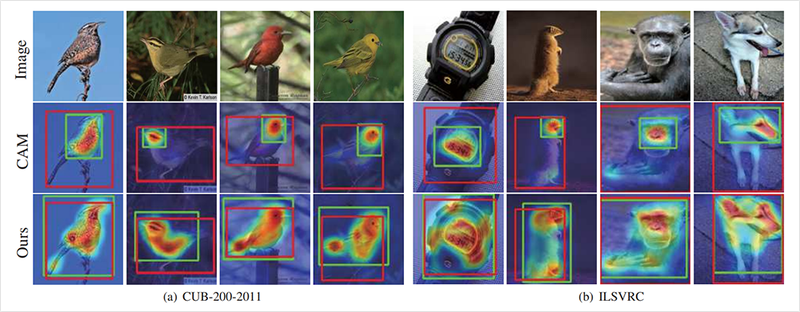

* CAM, Grad-CAM을 통해 비지도 학습의 가능성을 보여주지만 물체의 가장자리를 검출하는 것이 아니라 물체의 특징을 중심으로 활성화 되는 모습을 볼 수 있습니다.

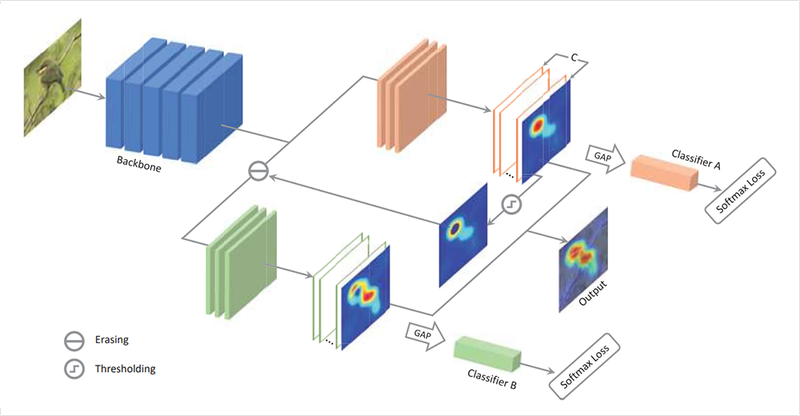
* ACoL 에서 Adversarial 은 너무 높은 활성화 부분을 지워줌(Threadholding)으로서 주변 특성을 반영하도록 하였습니다.

# 연습

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import warnings
warnings.filterwarnings(action='ignore')

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 데이터 불러오기

In [5]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    with_info=True)

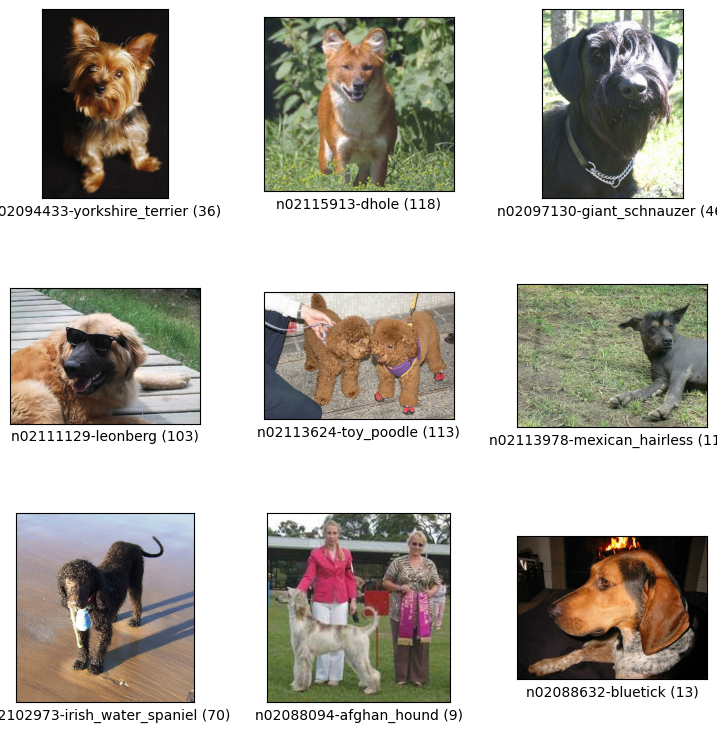

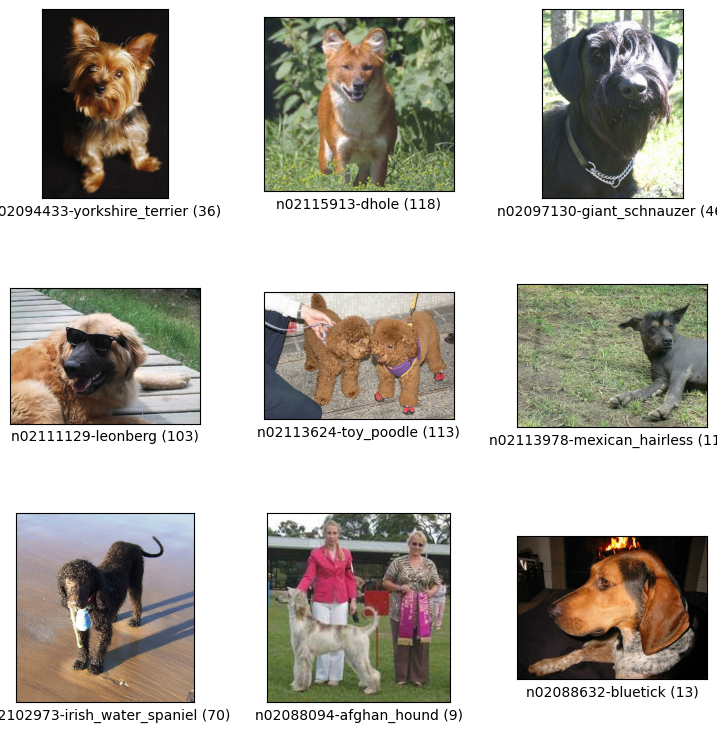

In [6]:
tfds.show_examples(ds_train, ds_info)

In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
    }),
})

## CAM

In [9]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,     # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [10]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

### key
* CAM은 특성 맵(feature map)을 사용해 만듭니다. 위 레이어들 중 우리가 사용하는 특성 맵은 어떤 레이어의 출력값일까요? 해당 레이어의 이름을 찾아보세요.

    > * conv5_block3_out의 output이 feature map이 됩니다. (마지막 레이어만 사용)
    > * 따라서 이 feature map에 Global average pooling을 하여 feature의 크기를 줄이고
    > * feature 전체에 Dense layer를 붙여 classification을 수행하게 됩니다.

In [11]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [12]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


## 모델 학습하기

In [13]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [14]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=2,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/2
750/750 [==============================] - 156s 172ms/step - loss: 2.2533 - accuracy: 0.4360 - val_loss: 3.5151 - val_accuracy: 0.1826
Epoch 2/2
750/750 [==============================] - 130s 173ms/step - loss: 0.5962 - accuracy: 0.8456 - val_loss: 1.3063 - val_accuracy: 0.6200


모델을 저장한 뒤, 사용했던 변수들 제거 (메모리 이슈)

In [15]:
cam_model_path = './cam_model1.h5'
cam_model.save(cam_model_path)

del(history_cam_model)
del(cam_model)
del(ds_train_norm)
del(ds_val_norm)

## CAM 확인하기

이미지 한 장을 가져옵니다.

In [17]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

67


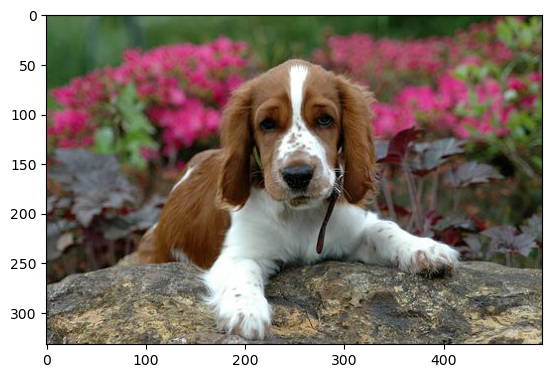

In [18]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

학습했던 모델을 불러옵니다.

In [19]:
cam_model = tf.keras.models.load_model(cam_model_path)

* CAM을 생성하기 위해서는
    1. 특성 맵,
    2. 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치
    3. 원하는 클래스의 출력값이 필요합니다

In [21]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

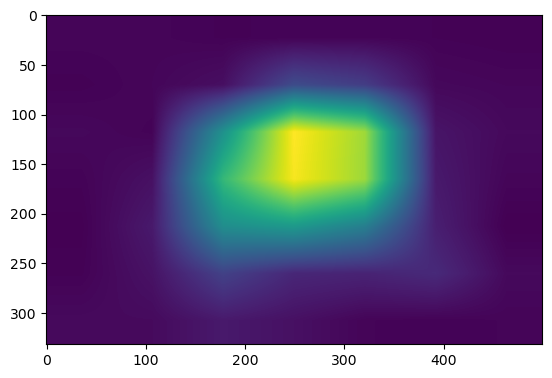

In [22]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

이렇게 얻은 CAM 이미지와 원본이미지를 적절하게 합쳐봅니다.

In [27]:
def visualize_cam_on_image(src1, src2, alpha=0.7):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

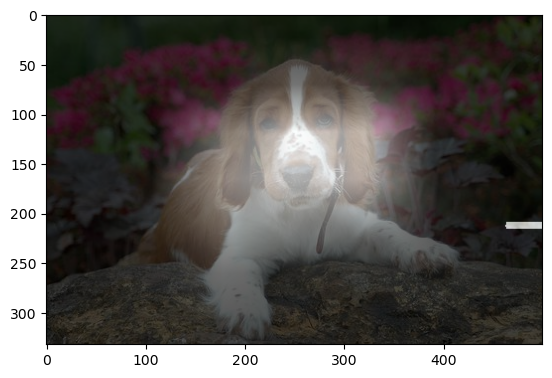

In [28]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

CAM이 개를 식별하는데 중요한 부분을 잘 포착하는지 확인합니다.

# Grad-CAM

같은 데이터를 Grad-CAM으로 확인해 봅니다.

67


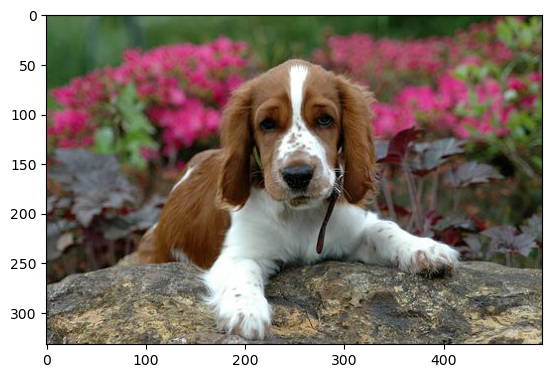

In [31]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

* Grad-CAM은 어떤 레이어에서든 CAM을 뽑아낼 수 있습니다.
* 어떤 레이어를 추출할지도 input으로 확인받습니다.

In [32]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

마지막 Conv_block 의 CAM

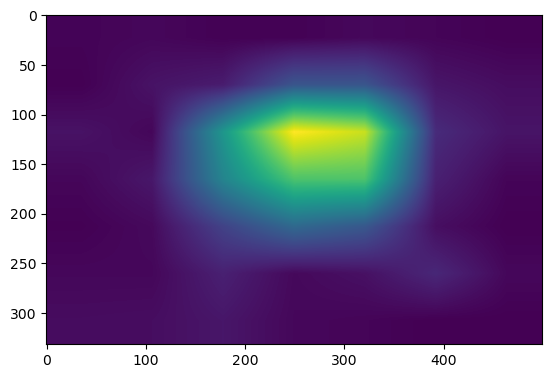

In [60]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

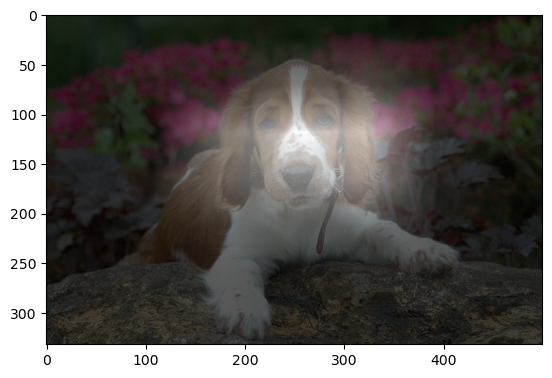

In [41]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

4번째 Conv_block 의 CAM

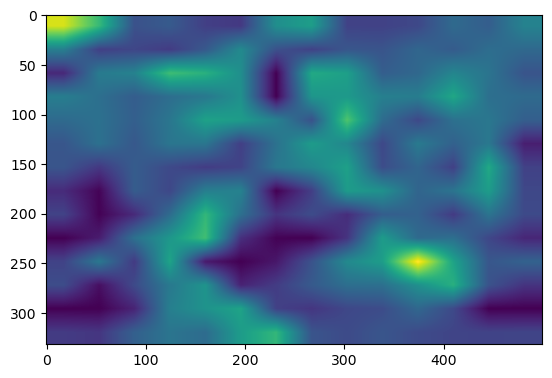

In [42]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

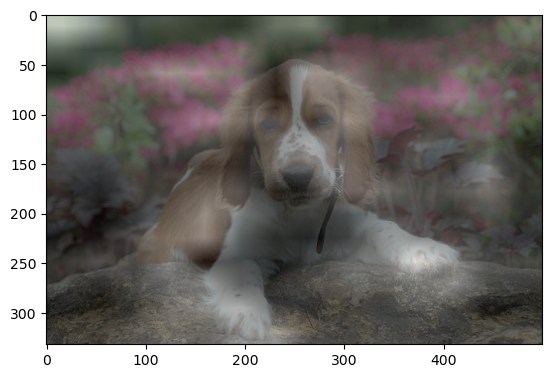

In [43]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

세번째 Conv_block의 CAM

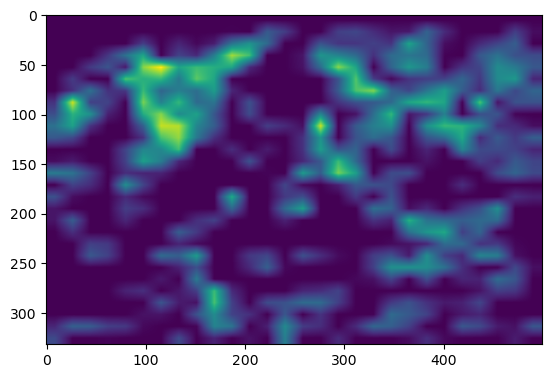

In [44]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

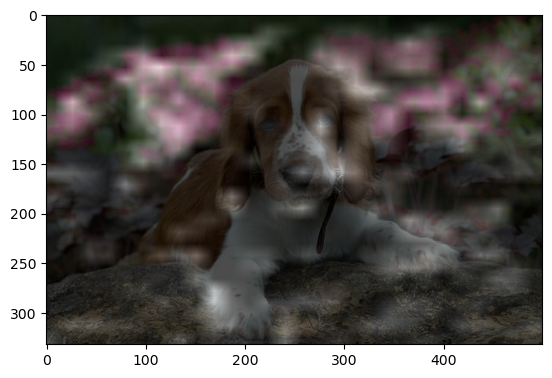

In [45]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

# CAM을 이용하여  Detection

* CAM이미지를 추출합니다.
* score_thresh의 값 아래의 BBox는 제거합니다.
* 적절한 사각형을 찾습니다.

In [65]:
def get_bbox(cam_image, score_thresh=0.1):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # 윤곽선 따기
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt) # 적절한 사각형 찾기
    rect = cv2.boxPoints(rotated_rect) # 사각형의 꼭지점
    rect = np.int0(rect)
    return rect

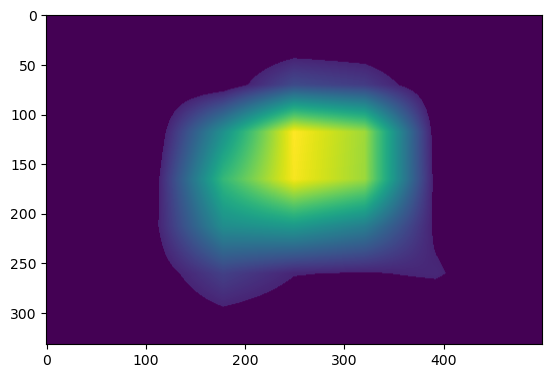

In [81]:
plt.imshow(cam_image)
plt.show()

In [82]:
rect = get_bbox(cam_image)
rect

array([[ 93,  64],
       [375,  27],
       [406, 264],
       [124, 300]], dtype=int64)

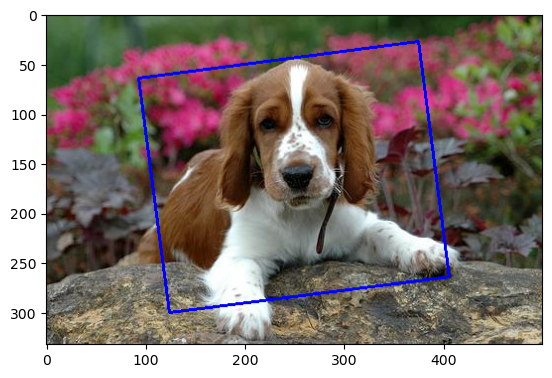

In [83]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

## 추론한 BBox와 실제값을 비교합니다.

In [84]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [85]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.08132530120481928, 0.186, 0.9036144578313253, 0.812]

In [86]:
item['objects']['bbox']

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

In [87]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [88]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.7836216707506626

# Grad-CAM을 이용한 detection과 비교

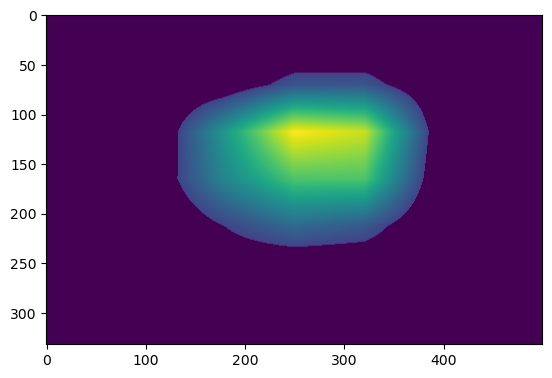

In [78]:
plt.imshow(grad_cam_image)
plt.show()

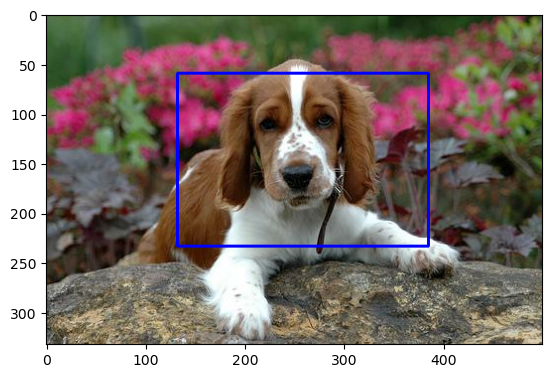

In [90]:
image = copy.deepcopy(item['image'])
rect = get_bbox(grad_cam_image)
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [92]:
pred_bbox = rect_to_minmax(rect, item['image'])
get_iou(pred_bbox, item['objects']['bbox'][0])

0.4575140409807625

* score_thresh 를 0.1 했을때 CAM의 값이 높게 나오는 것을 볼 수 있다.
* Detection을 수행하는데 있어는 Grad-CAM보다 CAM 더 좋게 나타났는데 grad값으로 어떤 부분이 얼마나 활성화 됐는지 확인하는 개념과 수행하려는 과제의 내용이 다른 부분이 있기때문인것 같다. 또한 마지막 레이어가 아닌 중간 레이어의 CAM값으로는 detection을 수행할 수 없으니 CAM을 선택하는 것이 더 좋아보인다.